In [1]:
%config IPCompleter.greedy=True
%load_ext tensorboard

In [1]:
import pandas as pd
df = pd.read_csv('kc_house_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [2]:
pd.options.display.max_columns = 10
df.head()

,id,date,price,bedrooms,bathrooms,...,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,...,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,...,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,...,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,...,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,...,98074,47.6168,-122.045,1800,7503


In [4]:
df['year'] = pd.to_numeric(df['date'].str.slice(0,4))
df['month'] = pd.to_numeric(df['date'].str.slice(4,6))
df['day'] = pd.to_numeric(df['date'].str.slice(6,8))
df.drop(['id', 'date'], axis='columns', inplace=True)
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,...,sqft_living15,sqft_lot15,year,month,day
0,221900.0,3,1.00,1180,5650,...,1340,5650,2014,10,13
1,538000.0,3,2.25,2570,7242,...,1690,7639,2014,12,9
2,180000.0,2,1.00,770,10000,...,2720,8062,2015,2,25
3,604000.0,4,3.00,1960,5000,...,1360,5000,2014,12,9
4,510000.0,3,2.00,1680,8080,...,1800,7503,2015,2,18


In [6]:
import numpy as np
data_num = df.shape[0]
indexes = np.random.permutation(data_num)
train_indexes = indexes[:int(data_num * 0.6)]
val_indexes = indexes[int(data_num * 0.6):int(data_num * 0.8)]
test_indexes = indexes[int(data_num * 0.8):]
train_data = df.loc[train_indexes]
val_data = df.loc[val_indexes]
test_data = df.loc[test_indexes]
mean = df.loc[indexes[:int(data_num * 0.8)]].mean()
std = df.loc[indexes[:int(data_num * 0.8)]].std()

train_data = (train_data-mean)/std
val_data = (val_data-mean)/std
x_train = np.array(train_data.drop('price', axis='columns'))
y_train = np.array(train_data['price'])
x_val = np.array(val_data.drop('price', axis='columns'))
y_val = np.array(val_data['price'])
x_train.shape

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


(12967, 21)

In [8]:
import tensorflow as tf
from tensorflow import keras
model_1 = tf.keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(21, )),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1),
], name='model-1')
model_1.summary()

Model: "model-1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                1408      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 5,633
Trainable params: 5,633
Non-trainable params: 0
_________________________________________________________________


In [7]:
model_1.compile(keras.optimizers.Adam(0.001),
               loss = keras.losses.MeanSquaredError(),
               metrics= [keras.metrics.MeanAbsoluteError()])

In [9]:
import os
log_dir = os.path.join('lab2-logs','model-1')
model_cbk = keras.callbacks.TensorBoard(log_dir = log_dir)

model_dir = 'lab2-logs/models/'
#os.makedirs(model_dir)

model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-Model-1.h5',
                                            monitor='val_mean_absolute_error',
                                            save_best_only=True,
                                            mode='min')

history = model_1.fit(x_train, y_train, batch_size=64, epochs=300,
                     validation_data=(x_val, y_val),
                      callbacks=[model_cbk, model_mckp])

Train on 12967 samples, validate on 4323 samples
Epoch 1/300
12967/12967 [==============================] - 1s 60us/sample - loss: 0.3325 - mean_absolute_error: 0.3616 - val_loss: 0.2311 - val_mean_absolute_error: 0.2942
Epoch 2/300
12967/12967 [==============================] - 0s 33us/sample - loss: 0.2015 - mean_absolute_error: 0.2800 - val_loss: 0.1975 - val_mean_absolute_error: 0.2714
Epoch 3/300
12967/12967 [==============================] - 0s 29us/sample - loss: 0.1711 - mean_absolute_error: 0.2575 - val_loss: 0.1820 - val_mean_absolute_error: 0.2535
Epoch 4/300
12967/12967 [==============================] - 0s 26us/sample - loss: 0.1528 - mean_absolute_error: 0.2421 - val_loss: 0.1652 - val_mean_absolute_error: 0.2465
Epoch 5/300
12967/12967 [==============================] - 0s 28us/sample - loss: 0.1385 - mean_absolute_error: 0.2327 - val_loss: 0.1598 - val_mean_absolute_error: 0.2424
Epoch 6/300
12967/12967 [==============================] - 0s 28us/sample - loss: 0.1337 - 

12967/12967 [==============================] - 0s 26us/sample - loss: 0.0404 - mean_absolute_error: 0.1435 - val_loss: 0.1335 - val_mean_absolute_error: 0.2098
Epoch 96/300
12967/12967 [==============================] - 0s 30us/sample - loss: 0.0402 - mean_absolute_error: 0.1432 - val_loss: 0.1420 - val_mean_absolute_error: 0.2076
Epoch 97/300
12967/12967 [==============================] - 0s 24us/sample - loss: 0.0401 - mean_absolute_error: 0.1430 - val_loss: 0.1368 - val_mean_absolute_error: 0.2067
Epoch 98/300
12967/12967 [==============================] - 0s 28us/sample - loss: 0.0450 - mean_absolute_error: 0.1483 - val_loss: 0.1463 - val_mean_absolute_error: 0.2113
Epoch 99/300
12967/12967 [==============================] - 0s 27us/sample - loss: 0.0415 - mean_absolute_error: 0.1447 - val_loss: 0.1537 - val_mean_absolute_error: 0.2107
Epoch 100/300
12967/12967 [==============================] - 0s 28us/sample - loss: 0.0411 - mean_absolute_error: 0.1443 - val_loss: 0.1364 - val_me

12967/12967 [==============================] - 0s 24us/sample - loss: 0.0318 - mean_absolute_error: 0.1293 - val_loss: 0.1633 - val_mean_absolute_error: 0.2205
Epoch 190/300
12967/12967 [==============================] - 0s 26us/sample - loss: 0.0295 - mean_absolute_error: 0.1266 - val_loss: 0.1528 - val_mean_absolute_error: 0.2143
Epoch 191/300
12967/12967 [==============================] - 0s 33us/sample - loss: 0.0304 - mean_absolute_error: 0.1278 - val_loss: 0.1500 - val_mean_absolute_error: 0.2142
Epoch 192/300
12967/12967 [==============================] - 0s 26us/sample - loss: 0.0332 - mean_absolute_error: 0.1321 - val_loss: 0.1594 - val_mean_absolute_error: 0.2217
Epoch 193/300
12967/12967 [==============================] - 0s 24us/sample - loss: 0.0301 - mean_absolute_error: 0.1280 - val_loss: 0.1512 - val_mean_absolute_error: 0.2139
Epoch 194/300
12967/12967 [==============================] - 0s 24us/sample - loss: 0.0311 - mean_absolute_error: 0.1284 - val_loss: 0.1569 - va

Epoch 283/300
12967/12967 [==============================] - 0s 24us/sample - loss: 0.0262 - mean_absolute_error: 0.1202 - val_loss: 0.1483 - val_mean_absolute_error: 0.2202
Epoch 284/300
12967/12967 [==============================] - 0s 25us/sample - loss: 0.0264 - mean_absolute_error: 0.1202 - val_loss: 0.1572 - val_mean_absolute_error: 0.2209
Epoch 285/300
12967/12967 [==============================] - 0s 25us/sample - loss: 0.0298 - mean_absolute_error: 0.1238 - val_loss: 0.1523 - val_mean_absolute_error: 0.2179
Epoch 286/300
12967/12967 [==============================] - 0s 25us/sample - loss: 0.0319 - mean_absolute_error: 0.1270 - val_loss: 0.1566 - val_mean_absolute_error: 0.2205
Epoch 287/300
12967/12967 [==============================] - 0s 24us/sample - loss: 0.0310 - mean_absolute_error: 0.1264 - val_loss: 0.1481 - val_mean_absolute_error: 0.2163
Epoch 288/300
12967/12967 [==============================] - 0s 24us/sample - loss: 0.0258 - mean_absolute_error: 0.1189 - val_los

In [10]:
history.history.keys()

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])

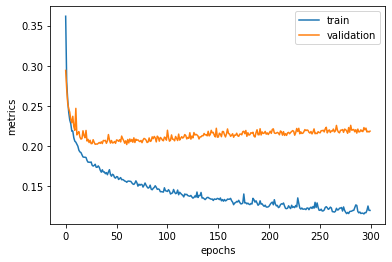

In [11]:
import matplotlib.pyplot as plt
plt.plot(history.history['mean_absolute_error'], label='train')
plt.plot(history.history['val_mean_absolute_error'], label='validation')
plt.ylabel('metrics')
plt.xlabel('epochs')
plt.legend(loc='upper right')

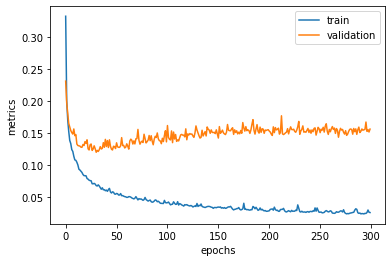

In [12]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylabel('metrics')
plt.xlabel('epochs')
plt.legend(loc='upper right')

In [13]:
model_2 = tf.keras.Sequential([
    keras.layers.Dense(16, activation='relu', input_shape=(21, )),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1)
], name='model-2')
model_2.summary()

model_2.compile(keras.optimizers.Adam(0.001),
               loss = keras.losses.MeanSquaredError(),
               metrics= [keras.metrics.MeanAbsoluteError()])

log_dir = os.path.join('lab2-logs','model-2')
model_cbk = keras.callbacks.TensorBoard(log_dir = log_dir)

model_dir = 'lab2-logs/models/'
#os.makedirs(model_dir)

model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-Model-2.h5',
                                            monitor='val_mean_absolute_error',
                                            save_best_only=True,
                                            mode='min')

history = model_2.fit(x_train, y_train, batch_size=64, epochs=300,
                     validation_data=(x_val, y_val),
                      callbacks=[model_cbk, model_mckp])

Model: "model-2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 16)                352       
_________________________________________________________________
dense_4 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 641
Trainable params: 641
Non-trainable params: 0
_________________________________________________________________
Train on 12967 samples, validate on 4323 samples
Epoch 1/300
12967/12967 [==============================] - 1s 66us/sample - loss: 0.5083 - mean_absolute_error: 0.4363 - val_loss: 0.3282 - val_mean_absolute_error: 0.3431
Epoch 2/300
12967/12967 [==============================] - 0s 27us/sample - loss: 0.2667 - mean_absolute_error: 0.3239 - val_loss: 0.2633 - val_mean_absolute_error: 0.308

Epoch 44/300
12967/12967 [==============================] - ETA: 0s - loss: 0.1006 - mean_absolute_error: 0.197 - 0s 23us/sample - loss: 0.1024 - mean_absolute_error: 0.1996 - val_loss: 0.1385 - val_mean_absolute_error: 0.2100
Epoch 45/300
12967/12967 [==============================] - 0s 23us/sample - loss: 0.1012 - mean_absolute_error: 0.1987 - val_loss: 0.1325 - val_mean_absolute_error: 0.2065
Epoch 46/300
12967/12967 [==============================] - 0s 22us/sample - loss: 0.1009 - mean_absolute_error: 0.1993 - val_loss: 0.1343 - val_mean_absolute_error: 0.2088
Epoch 47/300
12967/12967 [==============================] - 0s 24us/sample - loss: 0.1014 - mean_absolute_error: 0.1988 - val_loss: 0.1325 - val_mean_absolute_error: 0.2076
Epoch 48/300
12967/12967 [==============================] - 0s 24us/sample - loss: 0.1003 - mean_absolute_error: 0.1988 - val_loss: 0.1270 - val_mean_absolute_error: 0.2044
Epoch 49/300
12967/12967 [==============================] - 0s 23us/sample - loss

Epoch 91/300
12967/12967 [==============================] - 0s 23us/sample - loss: 0.0908 - mean_absolute_error: 0.1931 - val_loss: 0.1232 - val_mean_absolute_error: 0.2037
Epoch 92/300
12967/12967 [==============================] - 0s 23us/sample - loss: 0.0908 - mean_absolute_error: 0.1927 - val_loss: 0.1256 - val_mean_absolute_error: 0.2056
Epoch 93/300
12967/12967 [==============================] - 0s 23us/sample - loss: 0.0909 - mean_absolute_error: 0.1921 - val_loss: 0.1291 - val_mean_absolute_error: 0.2060
Epoch 94/300
12967/12967 [==============================] - 0s 23us/sample - loss: 0.0894 - mean_absolute_error: 0.1909 - val_loss: 0.1238 - val_mean_absolute_error: 0.2030
Epoch 95/300
12967/12967 [==============================] - 0s 24us/sample - loss: 0.0905 - mean_absolute_error: 0.1913 - val_loss: 0.1244 - val_mean_absolute_error: 0.2053
Epoch 96/300
12967/12967 [==============================] - 0s 25us/sample - loss: 0.0894 - mean_absolute_error: 0.1910 - val_loss: 0.1

Epoch 138/300
12967/12967 [==============================] - 0s 23us/sample - loss: 0.0831 - mean_absolute_error: 0.1857 - val_loss: 0.1224 - val_mean_absolute_error: 0.2026
Epoch 139/300
12967/12967 [==============================] - 0s 23us/sample - loss: 0.0819 - mean_absolute_error: 0.1838 - val_loss: 0.1234 - val_mean_absolute_error: 0.2002
Epoch 140/300
12967/12967 [==============================] - 0s 24us/sample - loss: 0.0819 - mean_absolute_error: 0.1847 - val_loss: 0.1266 - val_mean_absolute_error: 0.2023
Epoch 141/300
12967/12967 [==============================] - 0s 23us/sample - loss: 0.0816 - mean_absolute_error: 0.1847 - val_loss: 0.1235 - val_mean_absolute_error: 0.2022
Epoch 142/300
12967/12967 [==============================] - 0s 23us/sample - loss: 0.0838 - mean_absolute_error: 0.1853 - val_loss: 0.1261 - val_mean_absolute_error: 0.2074
Epoch 143/300
12967/12967 [==============================] - 0s 23us/sample - loss: 0.0827 - mean_absolute_error: 0.1845 - val_los

Epoch 185/300
12967/12967 [==============================] - 0s 23us/sample - loss: 0.0795 - mean_absolute_error: 0.1820 - val_loss: 0.1244 - val_mean_absolute_error: 0.2035
Epoch 186/300
12967/12967 [==============================] - 0s 23us/sample - loss: 0.0784 - mean_absolute_error: 0.1807 - val_loss: 0.1243 - val_mean_absolute_error: 0.1993
Epoch 187/300
12967/12967 [==============================] - 0s 23us/sample - loss: 0.0781 - mean_absolute_error: 0.1805 - val_loss: 0.1280 - val_mean_absolute_error: 0.2093
Epoch 188/300
12967/12967 [==============================] - 0s 23us/sample - loss: 0.0789 - mean_absolute_error: 0.1824 - val_loss: 0.1245 - val_mean_absolute_error: 0.2052
Epoch 189/300
12967/12967 [==============================] - 0s 23us/sample - loss: 0.0793 - mean_absolute_error: 0.1829 - val_loss: 0.1235 - val_mean_absolute_error: 0.2013
Epoch 190/300
12967/12967 [==============================] - 0s 23us/sample - loss: 0.0783 - mean_absolute_error: 0.1806 - val_los

Epoch 232/300
12967/12967 [==============================] - 0s 23us/sample - loss: 0.0769 - mean_absolute_error: 0.1804 - val_loss: 0.1277 - val_mean_absolute_error: 0.1989
Epoch 233/300
12967/12967 [==============================] - 0s 23us/sample - loss: 0.0771 - mean_absolute_error: 0.1800 - val_loss: 0.1254 - val_mean_absolute_error: 0.2002
Epoch 234/300
12967/12967 [==============================] - 0s 23us/sample - loss: 0.0767 - mean_absolute_error: 0.1787 - val_loss: 0.1273 - val_mean_absolute_error: 0.2007
Epoch 235/300
12967/12967 [==============================] - 0s 24us/sample - loss: 0.0771 - mean_absolute_error: 0.1795 - val_loss: 0.1254 - val_mean_absolute_error: 0.2017
Epoch 236/300
12967/12967 [==============================] - 0s 23us/sample - loss: 0.0767 - mean_absolute_error: 0.1790 - val_loss: 0.1259 - val_mean_absolute_error: 0.1997
Epoch 237/300
12967/12967 [==============================] - 0s 23us/sample - loss: 0.0769 - mean_absolute_error: 0.1791 - val_los

In [14]:
model_4 = tf.keras.Sequential([
    keras.layers.Dense(16, activation='relu', input_shape=(21, )),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1)
], name='model-2')
model_4.summary()

model_4.compile(keras.optimizers.Adam(0.001),
               loss = keras.losses.MeanSquaredError(),
               metrics= [keras.metrics.MeanAbsoluteError()])

log_dir = os.path.join('lab2-logs','model-4')
model_cbk = keras.callbacks.TensorBoard(log_dir = log_dir)

model_dir = 'lab2-logs/models/'
#os.makedirs(model_dir)

model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-Model-4.h5',
                                            monitor='val_mean_absolute_error',
                                            save_best_only=True,
                                            mode='min')

history = model_4.fit(x_train, y_train, batch_size=64, epochs=300,
                     validation_data=(x_val, y_val),
                      callbacks=[model_cbk, model_mckp])

Model: "model-2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 16)                352       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 17        
Total params: 641
Trainable params: 641
Non-trainable params: 0
_________________________________________________________________
Train on 12967 samples, validate on 4323 samples
Epoch 1/300
12967/12967 [==============================] - 1s 62us/sample - lo

12967/12967 [==============================] - 0s 24us/sample - loss: 0.2152 - mean_absolute_error: 0.2879 - val_loss: 0.2584 - val_mean_absolute_error: 0.2791
Epoch 90/300
12967/12967 [==============================] - 0s 25us/sample - loss: 0.2090 - mean_absolute_error: 0.2844 - val_loss: 0.2229 - val_mean_absolute_error: 0.2731
Epoch 91/300
12967/12967 [==============================] - 0s 24us/sample - loss: 0.2181 - mean_absolute_error: 0.2886 - val_loss: 0.2223 - val_mean_absolute_error: 0.2668
Epoch 92/300
12967/12967 [==============================] - 0s 24us/sample - loss: 0.2182 - mean_absolute_error: 0.2878 - val_loss: 0.2246 - val_mean_absolute_error: 0.2706
Epoch 93/300
12967/12967 [==============================] - 0s 24us/sample - loss: 0.2260 - mean_absolute_error: 0.2913 - val_loss: 0.2207 - val_mean_absolute_error: 0.2685
Epoch 94/300
12967/12967 [==============================] - 0s 24us/sample - loss: 0.2178 - mean_absolute_error: 0.2872 - val_loss: 0.2035 - val_mea

12967/12967 [==============================] - 0s 24us/sample - loss: 0.2120 - mean_absolute_error: 0.2841 - val_loss: 0.1891 - val_mean_absolute_error: 0.2585
Epoch 184/300
12967/12967 [==============================] - 0s 25us/sample - loss: 0.2148 - mean_absolute_error: 0.2871 - val_loss: 0.2548 - val_mean_absolute_error: 0.2800
Epoch 185/300
12967/12967 [==============================] - 0s 24us/sample - loss: 0.2220 - mean_absolute_error: 0.2881 - val_loss: 0.2098 - val_mean_absolute_error: 0.2591
Epoch 186/300
12967/12967 [==============================] - 0s 24us/sample - loss: 0.2070 - mean_absolute_error: 0.2843 - val_loss: 0.2023 - val_mean_absolute_error: 0.2622
Epoch 187/300
12967/12967 [==============================] - 0s 24us/sample - loss: 0.2112 - mean_absolute_error: 0.2847 - val_loss: 0.2218 - val_mean_absolute_error: 0.2664
Epoch 188/300
12967/12967 [==============================] - 0s 24us/sample - loss: 0.2246 - mean_absolute_error: 0.2888 - val_loss: 0.2044 - va

12967/12967 [==============================] - 0s 31us/sample - loss: 0.1988 - mean_absolute_error: 0.2833 - val_loss: 0.2366 - val_mean_absolute_error: 0.2770
Epoch 278/300
12967/12967 [==============================] - 0s 26us/sample - loss: 0.2094 - mean_absolute_error: 0.2860 - val_loss: 0.2250 - val_mean_absolute_error: 0.2713
Epoch 279/300
12967/12967 [==============================] - 0s 24us/sample - loss: 0.2157 - mean_absolute_error: 0.2886 - val_loss: 0.2405 - val_mean_absolute_error: 0.2676
Epoch 280/300
12967/12967 [==============================] - 0s 24us/sample - loss: 0.2108 - mean_absolute_error: 0.2841 - val_loss: 0.2019 - val_mean_absolute_error: 0.2563
Epoch 281/300
12967/12967 [==============================] - 0s 25us/sample - loss: 0.2209 - mean_absolute_error: 0.2838 - val_loss: 0.2136 - val_mean_absolute_error: 0.2705
Epoch 282/300
12967/12967 [==============================] - 0s 25us/sample - loss: 0.2090 - mean_absolute_error: 0.2841 - val_loss: 0.1931 - va

In [15]:
model_1.load_weights('lab2-logs/models/Best-Model-1.h5')
y_test = np.array(test_data['price'])
test_data = (test_data-mean)/std
x_test = np.array(test_data.drop('price', axis='columns'))
y_pred = model_1.predict(x_test)
y_pred = np.reshape(y_pred * std['price'] + mean['price'], y_test.shape)
percentage_error = np.mean(np.abs(y_test-y_pred)) / np.mean(y_test) * 100
print(f'model-1 percentage_error: {percentage_error:.2f} %')

model_2.load_weights('lab2-logs/models/Best-Model-2.h5')
y_pred = model_2.predict(x_test)
y_pred = np.reshape(y_pred * std['price'] + mean['price'], y_test.shape)
percentage_error = np.mean(np.abs(y_test-y_pred)) / np.mean(y_test) * 100
print(f'model-2 percentage_error: {percentage_error:.2f} %')

model_4.load_weights('lab2-logs/models/Best-Model-4.h5')
y_pred = model_4.predict(x_test)
y_pred = np.reshape(y_pred * std['price'] + mean['price'], y_test.shape)
percentage_error = np.mean(np.abs(y_test-y_pred)) / np.mean(y_test) * 100
print(f'model-4 percentage_error: {percentage_error:.2f} %')


model-1 percentage_error: 14.14 %
model-2 percentage_error: 14.03 %
model-4 percentage_error: 17.46 %


In [1]:
%tensorboard --logdir lab2-logs

UsageError: Line magic function `%tensorboard` not found.


# 心得

In [ ]:
房價預測的圖形中會有過擬合現象，因為在觀察中發現 validation有逐漸上升
可能是因為模型過於複雜和訓練資料過少，其實可以再增加訓練資料跟簡化模型。